In [3]:
%%capture
!pip install librosa
!pip install torch

In [2]:
import os
import pandas as pd
import s3fs
import zipfile
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import librosa
from scipy import signal
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
DATASET_PATH = "../data/LivingRoom_preprocessed_hack"

## Read Data

In [4]:
centroids_h1 = np.load(DATASET_PATH + "/Human1/centroid.npy")
centroids_h2 = np.load(DATASET_PATH + "/Human2/centroid.npy")
deconvoled_trim_h1 = np.load(DATASET_PATH + "/Human1/deconvoled_trim.npy")
deconvoled_trim_h2 = np.load(DATASET_PATH + "/Human2/deconvoled_trim.npy")

KeyboardInterrupt: 

In [ ]:
print("Deconvoled Trim Human 1 Shape: ", deconvoled_trim_h1.shape)
print("Deconvoled Trim Human 2 Shape: ", deconvoled_trim_h2.shape)
print("Centroids Huma 1 Shape: ", centroids_h1.shape)
print("Centroids Human 2 Shape: ", centroids_h2.shape)

Deconvoled Trim Human 1 Shape:  (1000, 4, 667200)
Deconvoled Trim Human 2 Shape:  (104, 4, 667200)
Centroids Huma 1 Shape:  (1000, 2)
Centroids Human 2 Shape:  (104, 2)
(1000, 2)
(104, 2)
[[-3231.3293467  -1127.87771457]
 [-3198.54107875  -744.5100656 ]
 [-3192.9776274   -248.26678827]
 ...
 [-1717.89923578 -3166.59648491]
 [-1808.60337549 -2779.13038427]
 [   44.43741322   106.48353609]]


## Normalize Coordinates

In [185]:
def normalize_coordinates(centroids):
    x_min = -4000
    x_max = 500
    y_min = -4000
    y_max = 2000

    room_width = x_max - x_min
    room_height = y_max - y_min

    centroids[:, 0] = (centroids[:, 0] - x_min) / room_width
    centroids[:, 1] = (centroids[:, 1] - y_min) / room_height
    return centroids

centroids_h1 = normalize_coordinates(centroids_h1)
centroids_h2 = normalize_coordinates(centroids_h2)

## Visualize Data

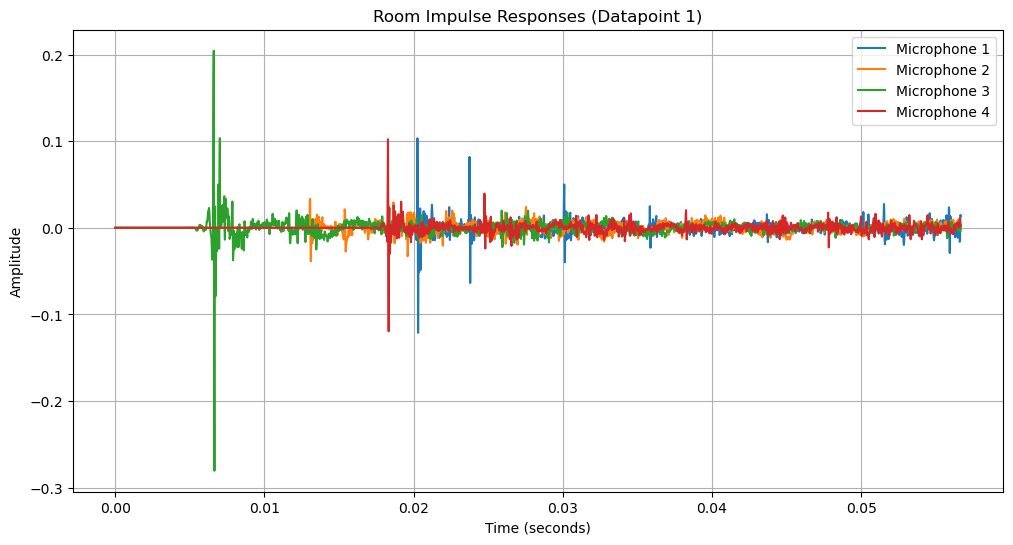

In [12]:
N_datapoints, N_Microphones, N_samples = deconvoled_trim_h1.shape

datapoint_index = 1  # Choose the datapoint index
time_sample_start = 0  # Start index of time samples
time_sample_end = 2500  # End index of time samples (or choose a specific range)

sampling_rate = 44100
time_axis = np.arange(time_sample_end - time_sample_start) / sampling_rate

# Plot the RIRs for each microphone channel
plt.figure(figsize=(12, 6))
for microphone_index in range(N_Microphones):
    # Extract the RIR for the current microphone channel
    rir = deconvoled_trim_h1[datapoint_index, microphone_index, time_sample_start:time_sample_end]
    
    # Plot the RIR on the same figure with different colors for each microphone
    plt.plot(time_axis, rir, label=f"Microphone {microphone_index + 1}")

plt.title(f"Room Impulse Responses (Datapoint {datapoint_index})")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()


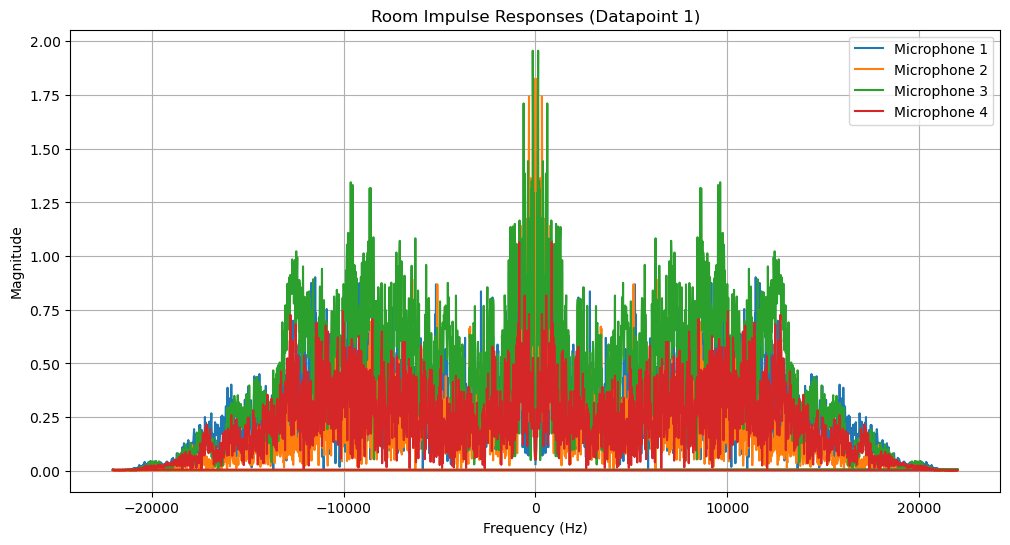

In [13]:
# Plot the RIRs for each microphone channel in the frequency domain
plt.figure(figsize=(12, 6))
for microphone_index in range(N_Microphones):
    # Extract the RIR for the current microphone channel
    rir = deconvoled_trim_h1[datapoint_index, microphone_index, time_sample_start:time_sample_end]
    
    # Compute the FFT
    rir_fft = np.fft.fft(rir)
    
    # Compute the frequency axis
    freq_axis = np.fft.fftfreq(len(rir), 1 / sampling_rate)
    
    # Plot the magnitude of the FFT (absolute value)
    plt.plot(freq_axis, np.abs(rir_fft), label=f"Microphone {microphone_index + 1}")

plt.title(f"Room Impulse Responses (Datapoint {datapoint_index})")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()
plt.show()

In [13]:
from sklearn.decomposition import IncrementalPCA

# Define the number of components for IPCA
n_components = 415

# Initialize IPCA
ipca_h1 = IncrementalPCA(n_components=n_components)
ipca_h2 = IncrementalPCA(n_components=n_components)

# Iterate over the data in batches and fit IPCA incrementally
batch_size = 500  # Adjust the batch size as needed
print("Fitting IPCA for Human 1:")
for i in tqdm(range(batch_size)):
    start = i * batch_size
    end = min((i + 1) * batch_size, reshaped_data_h1.shape[0])
    batch_data_h1 = reshaped_data_h1[start:end]
    ipca_h1.partial_fit(batch_data_h1)

print("Fitting IPCA for Human 2:")
for i in tqdm(range(batch_size)):
    start = i * batch_size
    end = min((i + 1) * batch_size, reshaped_data_h2.shape[0])
    batch_data_h2 = reshaped_data_h2[start:end]
    ipca_h2.partial_fit(batch_data_h2)

# Transform the data into the reduced dimensionality space
transformed_data_h1 = ipca_h1.transform(reshaped_data_h1)
transformed_data_h2 = ipca_h2.transform(reshaped_data_h2)
num_instances_h1, num_channels_h1, _ = deconvoled_trim_h1.shape
num_instances_h2, num_channels_h2, _ = deconvoled_trim_h2.shape

# Reshape the transformed data back to the original multi-channel shape
transformed_data_h1 = transformed_data_h1.reshape(num_instances_h1, num_channels_h1, -1)
transformed_data_h2 = transformed_data_h2.reshape(num_instances_h2, num_channels_h2, -1)

Fitting IPCA for Human 2:


  0%|          | 0/500 [00:00<?, ?it/s]

In [13]:
deconvoled_trim_h1 = "test"
deconvoled_trim_h2 = transformed_data

In [12]:
print(transformed_data.shape)

(104, 4, 94)


## Human 1

In [183]:
sampling_rate = 44100
preprocessed_data_mfcc = []
preprocessed_data_rms = []
preprocessed_data_zcr = []

start_time_index = 0
end_time_index = 50000

# Wrap the outer loop with tqdm for progress visualization
for instance_index in tqdm(range(deconvoled_trim_h1.shape[0])):
    instance_data_mfcc = []
    instance_data_zcr = []
    instance_data_rms = []
    for channel_index in range(deconvoled_trim_h1.shape[1]):
        channel_signal = deconvoled_trim_h1[instance_index, channel_index, :]
        focused_signal = channel_signal[start_time_index:end_time_index+1]
        # Filtering
        filtered_signal = signal.medfilt(focused_signal, kernel_size=3)
        
        # Normalization
        normalized_signal = librosa.util.normalize(filtered_signal)

        # Resampling
        resampled_signal = librosa.resample(normalized_signal, orig_sr=sampling_rate, target_sr=16000)
        
        # Feature extraction
        # MFCC features

        # Mel spectrogram
        mel_features = librosa.feature.melspectrogram(
            y=resampled_signal,
            sr=16000,
            n_fft=2048,
            hop_length=512,
            n_mels=128
        )
        mfcc_features = librosa.feature.mfcc(S=librosa.power_to_db(mel_features))

        # RMS features
        rms_features = np.sqrt(np.mean(resampled_signal**2))
        # rms_features = librosa.feature.rms(y=normalized_signal)

        # Zero-Crossing Rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=resampled_signal)
        
        instance_data_mfcc.append(mfcc_features)
        instance_data_zcr.append(zero_crossing_rate)
        instance_data_rms.append(rms_features)
    
    preprocessed_data_mfcc.append(instance_data_mfcc)
    preprocessed_data_rms.append(instance_data_rms)
    preprocessed_data_zcr.append(instance_data_zcr)

preprocessed_data_mfcc_h1 = np.array(preprocessed_data_mfcc)
preprocessed_data_rms_h1 = np.array(preprocessed_data_rms)
preprocessed_data_zcr_h1 = np.array(preprocessed_data_zcr)

  0%|          | 3/1000 [00:00<00:34, 28.73it/s]

100%|██████████| 1000/1000 [00:28<00:00, 34.97it/s]


## Human 2

In [184]:
sampling_rate = 44100
preprocessed_data_mfcc = []
preprocessed_data_rms = []
preprocessed_data_zcr = []

start_time_index = 0
end_time_index = 50000

# Wrap the outer loop with tqdm for progress visualization
for instance_index in tqdm(range(deconvoled_trim_h2.shape[0])):
    instance_data_mfcc = []
    instance_data_zcr = []
    instance_data_rms = []
    for channel_index in range(deconvoled_trim_h2.shape[1]):
        channel_signal = deconvoled_trim_h2[instance_index, channel_index, :]
        focused_signal = channel_signal[start_time_index:end_time_index+1]
        # Filtering
        filtered_signal = signal.medfilt(focused_signal, kernel_size=3)
        
        # Normalization
        normalized_signal = librosa.util.normalize(filtered_signal)

        # Resampling
        resampled_signal = librosa.resample(normalized_signal, orig_sr=sampling_rate, target_sr=16000)
        
        # Feature extraction
        # MFCC features

        # Mel spectrogram
        mel_features = librosa.feature.melspectrogram(
            y=resampled_signal,
            sr=16000,
            n_fft=2048,
            hop_length=512,
            n_mels=128
        )
        mfcc_features = librosa.feature.mfcc(S=librosa.power_to_db(mel_features))

        # RMS features
        rms_features = np.sqrt(np.mean(resampled_signal**2))
        # rms_features = librosa.feature.rms(y=normalized_signal)

        # Zero-Crossing Rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=resampled_signal)
        
        instance_data_mfcc.append(mfcc_features)
        instance_data_zcr.append(zero_crossing_rate)
        instance_data_rms.append(rms_features)
    
    preprocessed_data_mfcc.append(instance_data_mfcc)
    preprocessed_data_rms.append(instance_data_rms)
    preprocessed_data_zcr.append(instance_data_zcr)

preprocessed_data_mfcc_h2 = np.array(preprocessed_data_mfcc)
preprocessed_data_rms_h2 = np.array(preprocessed_data_rms)
preprocessed_data_zcr_h2 = np.array(preprocessed_data_zcr)

100%|██████████| 104/104 [00:02<00:00, 35.71it/s]


In [115]:
def plot_audio_features(instance_index, channel_index, mfcc_features=[], rms_features=[], zero_crossing_rate=[]):
    if len(mfcc_features) > 0:
        # Plot MFCC features
        plt.figure(figsize=(10, 4))
        plt.imshow(mfcc_features, cmap='viridis', origin='lower', aspect='auto')
        plt.xlabel('Frame')
        plt.ylabel('MFCC Coefficient')
        plt.title('MFCC Features (Instance {}, Channel {})'.format(instance_index+1, channel_index+1))
        plt.colorbar(label='Magnitude')
        plt.tight_layout()
        plt.show()

    if len(rms_features) > 0:
        # Plot RMS Features for each channel
        for i, rms_channel in enumerate(rms_features):
            plt.figure(figsize=(10, 4))
            plt.plot(rms_channel, label=f'RMS Features (Channel {i+1})')
            plt.xlabel('Time (frame)')
            plt.ylabel('RMS Energy')
            plt.title('RMS Features (Instance {}, Channel {})'.format(instance_index+1, channel_index+1))
            plt.legend()
            plt.tight_layout()
            plt.show()

    if len(zero_crossing_rate) > 0:
        # Plot Zero-Crossing Rate for each channel
        for i, zcr_channel in enumerate(zero_crossing_rate):
            plt.figure(figsize=(10, 4))
            plt.plot(zcr_channel, label=f'Zero-Crossing Rate (Channel {i+1})')
            plt.xlabel('Time (frame)')
            plt.ylabel('Zero-Crossing Rate')
            plt.title('Zero-Crossing Rate (Instance {}, Channel {})'.format(instance_index+1, channel_index+1))
            plt.legend()
            plt.tight_layout()
            plt.show()

In [166]:
print("Preprocessed RMS Human 1 data: ", preprocessed_data_rms_h1.shape)
print("Preprocessed Zero-Crossing Rate Human 1 data: ", preprocessed_data_zcr_h1.shape)
print("Preprocessed MFCC Human 1 data: ", preprocessed_data_mfcc_h1.shape)
print("Preprocessed RMS Human 2 data: ", preprocessed_data_rms_h2.shape)
print("Preprocessed Zero-Crossing Rate Human 2 data: ", preprocessed_data_zcr_h2.shape)
print("Preprocessed MFCC Human 2 data: ", preprocessed_data_mfcc_h2.shape)

Preprocessed RMS Human 1 data:  (1000, 4)
Preprocessed Zero-Crossing Rate Human 1 data:  (1000, 4, 1, 36)
Preprocessed MFCC Human 1 data:  (1000, 4, 20, 36)
Preprocessed RMS Human 2 data:  (104, 4)
Preprocessed Zero-Crossing Rate Human 2 data:  (104, 4, 1, 36)
Preprocessed MFCC Human 2 data:  (104, 4, 20, 36)


In [172]:
from sklearn.decomposition import PCA

reshaped_mfcc_h1 = preprocessed_data_mfcc_h1.reshape((-1, preprocessed_data_mfcc_h1.shape[-1]))
reshaped_mfcc_h2 = preprocessed_data_mfcc_h2.reshape((-1, preprocessed_data_mfcc_h2.shape[-1]))

pca_h1 = PCA(n_components=0.95)
pca_h2 = PCA(n_components=0.95) 

pca_h1.fit(reshaped_mfcc_h1)
pca_h2.fit(reshaped_mfcc_h2)

transformed_mfcc_h1 = pca_h1.transform(reshaped_mfcc_h1)
transformed_mfcc_h2 = pca_h2.transform(reshaped_mfcc_h2)

inverse_transformed_mfcc_h1 = pca_h1.inverse_transform(transformed_mfcc_h1)
inverse_transformed_mfcc_h2 = pca_h2.inverse_transform(transformed_mfcc_h2)

inverse_transformed_mfcc_h1 = inverse_transformed_mfcc_h1.reshape(preprocessed_data_mfcc_h1.shape)
inverse_transformed_mfcc_h2 = inverse_transformed_mfcc_h2.reshape(preprocessed_data_mfcc_h2.shape)

print("Transformed MFCC Human 1 data shape:", transformed_mfcc_h1.shape)
print("Transformed MFCC Human 2 data shape:", transformed_mfcc_h2.shape)
print("Inverse transformed MFCC Human 1 data shape:", inverse_transformed_mfcc_h1.shape)
print("Inverse transformed MFCC Human 2 data shape:", inverse_transformed_mfcc_h2.shape)

Transformed MFCC Human 1 data shape: (80000, 1)
Transformed MFCC Human 2 data shape: (8320, 1)
Inverse transformed MFCC Human 1 data shape: (1000, 4, 20, 36)
Inverse transformed MFCC Human 2 data shape: (104, 4, 20, 36)


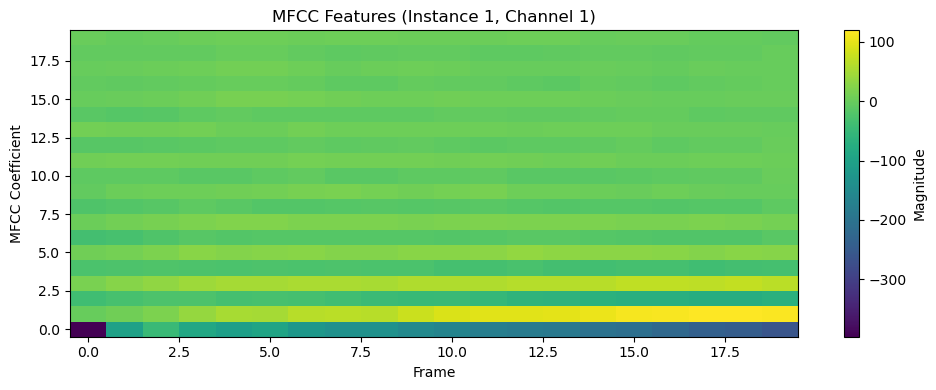

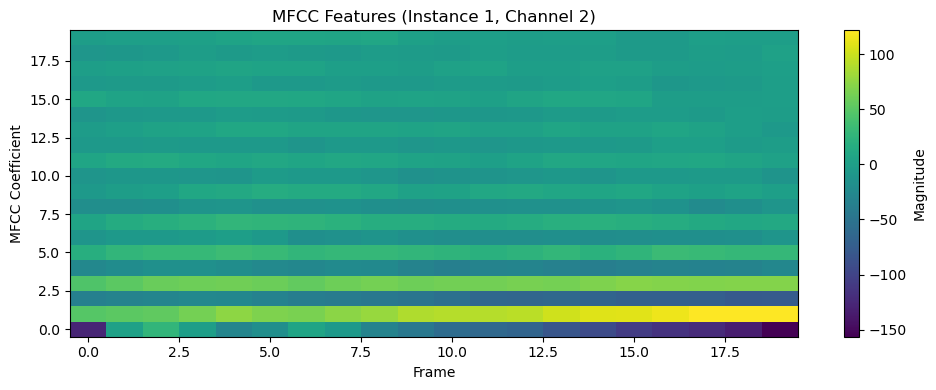

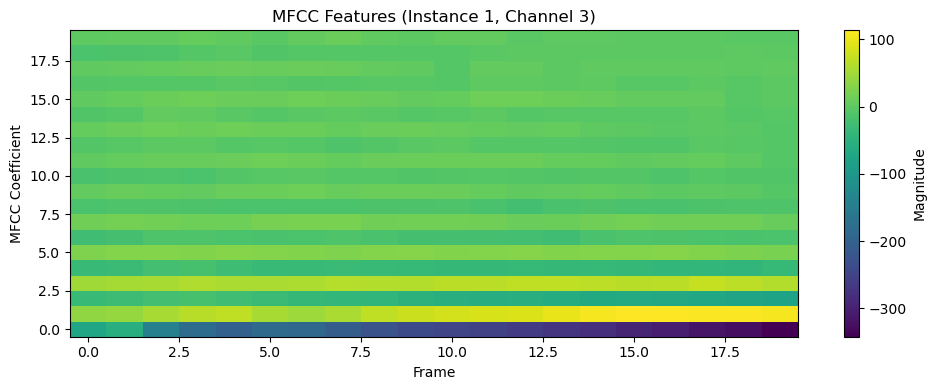

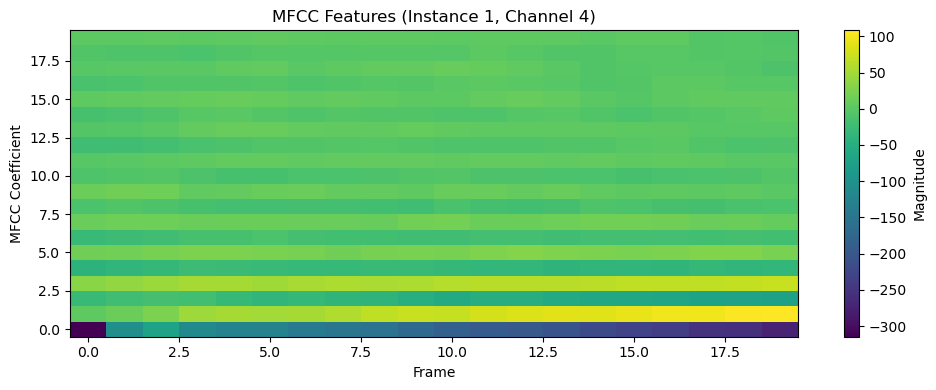

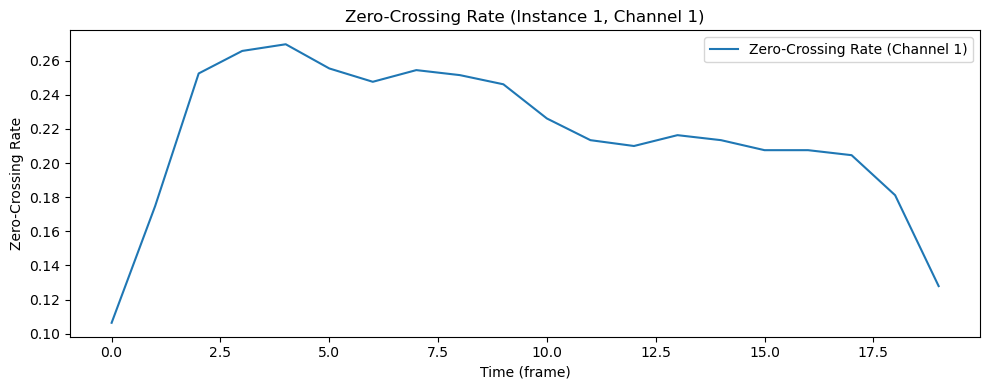

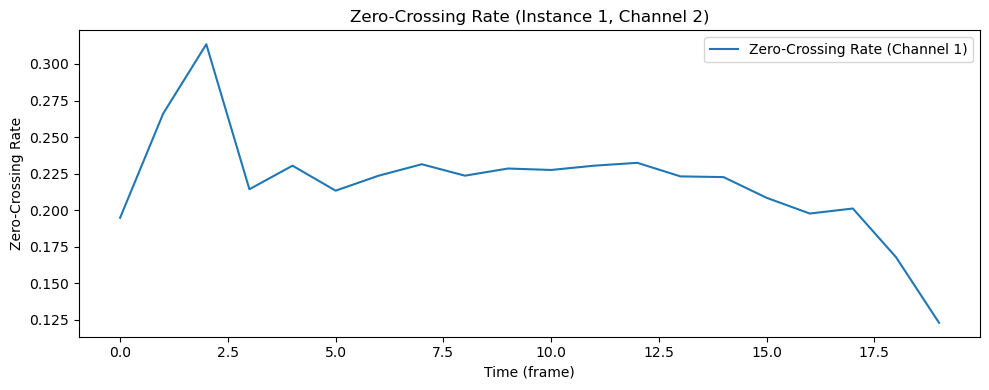

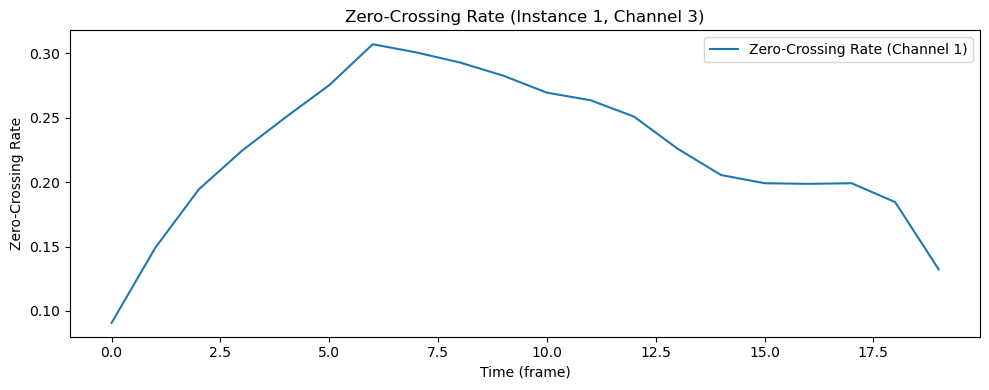

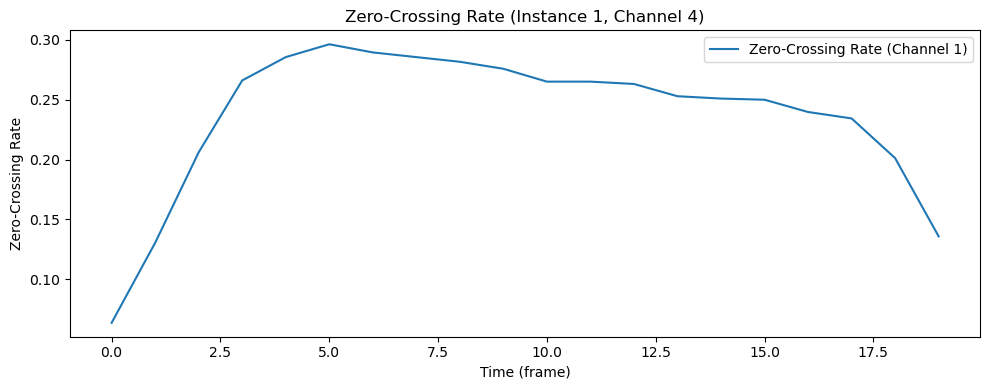

In [117]:
# Plot audio features for each instance and channel
#for instance_index in range(preprocessed_data_rms.shape[0]):
#    for channel_index in range(preprocessed_data_rms.shape[1]):
#        rms_features = preprocessed_data_rms[instance_index, channel_index]
#        plot_audio_features(rms_features=rms_features, instance_index=instance_index, channel_index=channel_index)
#    break

# Plot audio features for each instance and channel
for instance_index in range(preprocessed_data_mfcc_h2.shape[0]):
    for channel_index in range(preprocessed_data_mfcc_h2.shape[1]):
        mfcc_features = preprocessed_data_mfcc_h2[instance_index, channel_index]
        plot_audio_features(mfcc_features=mfcc_features, instance_index=instance_index, channel_index=channel_index)
    break

# Plot audio features for each instance and channel
for instance_index in range(preprocessed_data_zcr_h2.shape[0]):
    for channel_index in range(preprocessed_data_zcr_h2.shape[1]):
        zero_crossing_rate = preprocessed_data_zcr_h2[instance_index, channel_index] 
        plot_audio_features(zero_crossing_rate=zero_crossing_rate, instance_index=instance_index, channel_index=channel_index)
    break

## Dataset

In [175]:
class CustomDataset(Dataset):
    def __init__(self, coordinates, preprocessed_data_mfcc=[], _type="rms", preprocessed_data_rms=[], preprocessed_data_zcr=[]):
        self.preprocessed_data_mfcc = preprocessed_data_mfcc
        self.preprocessed_data_rms = preprocessed_data_rms
        self.preprocessed_data_zcr = preprocessed_data_zcr
        self.coordinates = coordinates
        self.type = _type
        if self.type == "rms":
            print("RMS: ", preprocessed_data_rms.shape)
        elif self.type == "zcr":
            print("ZCR: ", preprocessed_data_zcr.shape)
        elif self.type == "mfcc":
            print("MFCC: ", preprocessed_data_mfcc.shape)
        
    def __len__(self):
        return len(self.coordinates)

    def __getitem__(self, idx):
        coordinates = torch.tensor(self.coordinates[idx], dtype=torch.float32)
        if self.type == "rms":
            rms = self.preprocessed_data_rms[idx]
            rms = torch.tensor(rms, dtype=torch.float32)
            return np.array(rms), coordinates
        elif self.type == "mfcc":
            mfcc = [torch.tensor(self.preprocessed_data_mfcc[idx, mic_index], dtype=torch.float32) for mic_index in range(4)]
            return np.array(mfcc), coordinates
        elif self.type == "zcr":
            zcr = torch.tensor(self.preprocessed_data_zcr[idx], dtype=torch.float32) if self.preprocessed_data_zcr else None
            return np.array(zcr), coordinates
        else:
            print("Error type")
            return None, None

In [176]:
dataset_h1 = CustomDataset(preprocessed_data_rms=preprocessed_data_rms_h1, coordinates=centroids_h1)
dataset_h2 = CustomDataset(preprocessed_data_rms=preprocessed_data_rms_h2, coordinates=centroids_h2)

# Access a sample from the dataset
features_list, coordinates = dataset_h1[1]
print("Features List Length:", len(features_list))
print("Features Shape (Microphone 1):", features_list[0])
print("Features Shape (Microphone 2):", features_list[1])
print("Features Shape (Microphone 3):", features_list[2])
print("Features Shape (Microphone 4):", features_list[3])
print("Coordinates:", coordinates)

RMS:  (1000, 4)
RMS:  (104, 4)
Features List Length: 4
Features Shape (Microphone 1): 0.60093963
Features Shape (Microphone 2): 0.4396202
Features Shape (Microphone 3): 0.08166313
Features Shape (Microphone 4): 0.39898694
Coordinates: tensor([-3198.5410,  -744.5101])


## Linear Regression Model

In [177]:
class MyLinearRegression(nn.Module):
    def __init__(self, input_size=4, output_size=2):
        super(MyLinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out

In [178]:
batch_size = 64
train_loader = DataLoader(dataset=dataset_h1, batch_size=batch_size, shuffle=True)

## Training

In [179]:
input_size = 4  # 4 microphones
output_size = 2  # x, y coordinates
pytorch_model = MyLinearRegression(input_size=input_size, output_size=output_size)
sk_learn_model = LinearRegression()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(pytorch_model.parameters(), lr=0.0001)
num_epochs = 20

In [180]:
def euclidean_distance(pred_coords, true_coords):
    if not isinstance(pred_coords, np.ndarray):
        pred_coords = pred_coords.numpy()
    if not isinstance(true_coords, np.ndarray):
        pred_coords = true_coords.numpy()
    return np.sqrt(np.sum((pred_coords - true_coords)**2))

In [181]:
sk_learn_model.fit(dataset_h1.preprocessed_data_rms, dataset_h1.coordinates)

LinearRegression()

In [182]:
# Make predictions on the validation set
val_predictions = sk_learn_model.predict(dataset_h2.preprocessed_data_rms)

# Calculate localization errors for each prediction
errors = []
for pred_coords, true_coords in zip(val_predictions, dataset_h2.coordinates):
    error = euclidean_distance(pred_coords, true_coords)
    errors.append(error)

errors = np.array(errors)
mean_error = np.mean(errors)
stdev_error = np.std(errors)

print("Localization Error: {:.2f} ({:.2f})".format(mean_error, stdev_error))
print("Score: ", sk_learn_model.score(dataset_h1.preprocessed_data_rms, dataset_h1.coordinates))

Localization Error: 1637.05 (668.06)
Score:  0.05936372993517208


In [61]:
for epoch in range(num_epochs):
    pytorch_model.train()
    train_loss = 0.0
    for rms, coordinates in train_loader:
        optimizer.zero_grad()
        outputs = pytorch_model(rms)
        loss = criterion(outputs, coordinates)
        loss.backward()

In [62]:
pytorch_model.eval()
predicted_coordinates = []

for rms, coordinates in dataset_h2:
    # Forward pass to get the predicted coordinates
    with torch.no_grad():  # Disable gradient tracking during inference
        outputs = pytorch_model(torch.tensor(rms))
    
    # Append the predicted coordinates to the list
    predicted_coordinates.append(outputs)

# Convert the list of predicted coordinates to a single tensor
predicted_coordinates = np.array(predicted_coordinates)

In [63]:
errors = []
for pred_coords, true_coords in zip(predicted_coordinates, dataset_h2.coordinates):
    error = euclidean_distance(pred_coords, true_coords)
    errors.append(error)

errors = np.array(errors)
mean_error = np.mean(errors)
stdev_error = np.std(errors)

print("Localization Error: {:.2f} ({:.2f})".format(mean_error, stdev_error))

Localization Error: 2565.04 (1015.59)


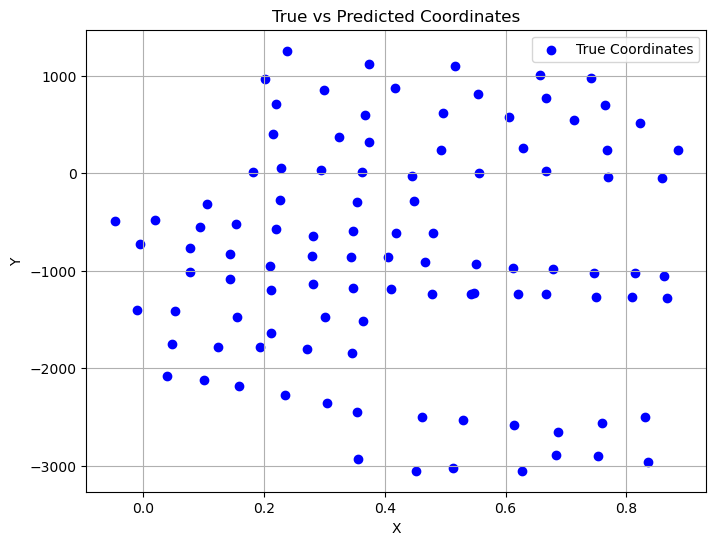

In [237]:
# Concatenate all true and predicted coordinates from all data points
all_true_coords = dataset_h2.coordinates.reshape(-1, 2)
all_pred_coords = predicted_coordinates.reshape(-1, 2)

# Plot all true and predicted coordinates on a single graph
plt.figure(figsize=(8, 6))
plt.scatter(all_true_coords[:, 0], all_true_coords[:, 1], color='blue', label='True Coordinates')
#plt.scatter(all_pred_coords[:, 0], all_pred_coords[:, 1], color='red', label='Predicted Coordinates')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('True vs Predicted Coordinates')
plt.legend()
plt.grid(True)
plt.show()


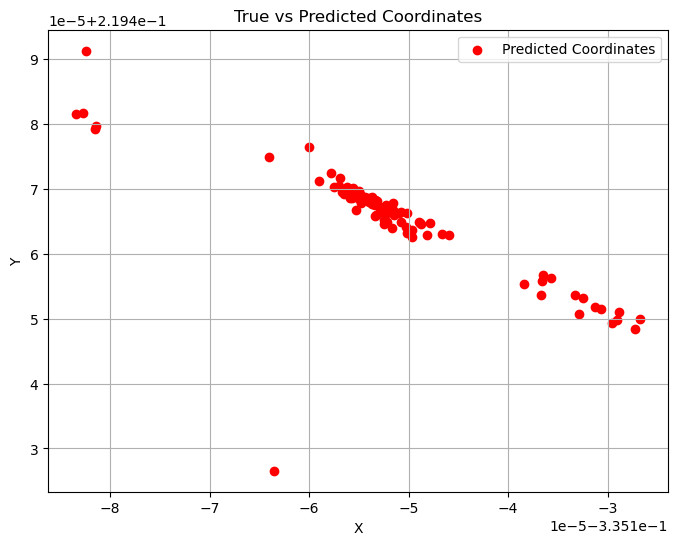

In [238]:
# Concatenate all true and predicted coordinates from all data points
all_true_coords = dataset_h2.coordinates.reshape(-1, 2)
all_pred_coords = predicted_coordinates.reshape(-1, 2)

# Plot all true and predicted coordinates on a single graph
plt.figure(figsize=(8, 6))
#plt.scatter(all_true_coords[:, 0], all_true_coords[:, 1], color='blue', label='True Coordinates')
plt.scatter(all_pred_coords[:, 0], all_pred_coords[:, 1], color='red', label='Predicted Coordinates')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('True vs Predicted Coordinates')
plt.legend()
plt.grid(True)
plt.show()

## Zero-Crossing Rate

In [240]:
dataset_h1 = CustomDataset(preprocessed_data_zcr=preprocessed_data_zcr_h1, _type="zcr", coordinates=centroids_h1)
dataset_h2 = CustomDataset(preprocessed_data_zcr=preprocessed_data_zcr_h2, _type="zcr", coordinates=centroids_h2)

# Split the data into training and testing sets
rms_features = np.sqrt(np.mean(dataset_h1.preprocessed_data_zcr**2, axis=-1))
X_train = rms_features.reshape(1000, 4)
y_train = dataset_h1.coordinates
rms_features = np.sqrt(np.mean(dataset_h2.preprocessed_data_zcr**2, axis=-1))
X_test = rms_features.reshape(104, 4)
y_test = dataset_h2.coordinates

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
# print("Score: ", model.score(X_test, y_test))

errors = []
for pred_coords, true_coords in zip(y_pred, dataset_h2.coordinates):
    error = euclidean_distance(pred_coords, true_coords)
    errors.append(error)

errors = np.array(errors)
mean_error = np.mean(errors)
stdev_error = np.std(errors)

print("Localization Error: {:.2f} ({:.2f})".format(mean_error, stdev_error))

ZCR:  (1000, 4, 1, 1304)
ZCR:  (104, 4, 1, 1304)
Localization Error: 1149.33 (828.45)
